# Performance Comparison: Pure Python vs C++ Extension

This document compares the computational performance of the pure Python implementation (`SplineFitter`) and the C++ optimized implementation (`SplineFitterCpp`) of the smoothing spline fitter.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from smoothing_spline.fitter import SplineFitter
from smoothing_spline.cpp_fitter import SplineFitterCpp

# Check if C++ extension is available
try:
    from smoothing_spline._spline_extension import SplineFitterCpp as _Ext
    CPP_AVAILABLE = True
    print("C++ Extension is AVAILABLE")
except ImportError:
    CPP_AVAILABLE = False
    print("C++ Extension is NOT available")

C++ Extension is AVAILABLE


## Speed Comparison at Different Scales

We will measure the time taken to fit the smoothing spline for different numbers of observations ($N$) and different numbers of knots ($K$).

In [2]:
def benchmark_fitters(ns, n_knots=None):
    results = {'py': [], 'cpp': []}
    
    for n in ns:
        rng = np.random.default_rng(42)
        x = np.sort(rng.uniform(0, 10, n))
        y = np.sin(x) + rng.normal(0, 0.1, n)
        
        # Pure Python
        start = time.time()
        fitter_py = SplineFitter(x, n_knots=n_knots, df=10)
        fitter_py.fit(y)
        results['py'].append(time.time() - start)
        
        # C++ Extension
        if CPP_AVAILABLE:
            start = time.time()
            fitter_cpp = SplineFitterCpp(x, n_knots=n_knots, df=10)
            fitter_cpp.fit(y)
            results['cpp'].append(time.time() - start)
        else:
            results['cpp'].append(np.nan)
            
    return results

# Sizes to test
ns = [100, 500, 1000, 2000, 5000]
print(f"Benchmarking with ns={ns}...")
results_all_knots = benchmark_fitters(ns)

Benchmarking with ns=[100, 500, 1000, 2000, 5000]...


## Results Visualization

### 1. All Unique X as Knots

When $N$ is small, using all unique $x$ values as knots is feasible. However, the complexity is $O(K^3)$ where $K$ is the number of knots. In this case $K=N$.

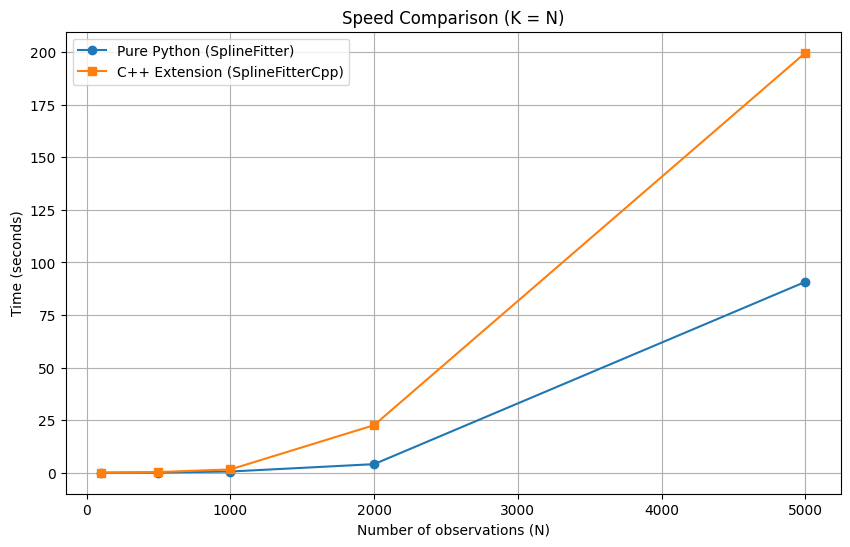

N= 100: Speedup = 7.98x
N= 500: Speedup = 0.30x
N=1000: Speedup = 0.37x
N=2000: Speedup = 0.18x
N=5000: Speedup = 0.45x


In [3]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ns, results_all_knots['py'], 'o-', label='Pure Python (SplineFitter)')
if CPP_AVAILABLE:
    ax.plot(ns, results_all_knots['cpp'], 's-', label='C++ Extension (SplineFitterCpp)')

ax.set_xlabel('Number of observations (N)')
ax.set_ylabel('Time (seconds)')
ax.set_title('Speed Comparison (K = N)')
ax.legend()
ax.grid(True)
plt.show()

if CPP_AVAILABLE:
    speedup = [p/c for p, c in zip(results_all_knots['py'], results_all_knots['cpp'])]
    for n, s in zip(ns, speedup):
        print(f"N={n:4d}: Speedup = {s:.2f}x")

### 2. Fixed Number of Knots (K=200)

In practice, for large $N$, we often limit the number of knots to a fixed $K \ll N$.

In [4]:
ns_large = [1000, 5000, 10000, 20000, 50000]
K = 200
print(f"Benchmarking with large N and K={K}...")
results_fixed_knots = benchmark_fitters(ns_large, n_knots=K)

Benchmarking with large N and K=200...


RuntimeError: Could not find root in the given bounds.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ns_large, results_fixed_knots['py'], 'o-', label=f'Pure Python (K={K})')
if CPP_AVAILABLE:
    ax.plot(ns_large, results_fixed_knots['cpp'], 's-', label=f'C++ Extension (K={K})')

ax.set_xlabel('Number of observations (N)')
ax.set_ylabel('Time (seconds)')
ax.set_title(f'Speed Comparison (Fixed K={K})')
ax.legend()
ax.grid(True)
plt.show()

if CPP_AVAILABLE:
    speedup_fixed = [p/c for p, c in zip(results_fixed_knots['py'], results_fixed_knots['cpp'])]
    for n, s in zip(ns_large, speedup_fixed):
        print(f"N={n:5d}: Speedup = {s:.2f}x")

## GCV Solve Performance

Automatic tuning with GCV involves multiple fits (or an optimized path). The C++ extension provides a highly optimized `solve_gcv` method.

In [ ]:
if CPP_AVAILABLE:
    n = 5000
    K = 200
    x = np.sort(np.random.uniform(0, 10, n))
    y = np.sin(x) + np.random.normal(0, 0.1, n)
    
    print(f"Benchmarking solve_gcv (N={n}, K={K})...")
    start = time.time()
    fitter = SplineFitterCpp(x, n_knots=K)
    best_lam = fitter.solve_gcv(y)
    cpp_gcv_time = time.time() - start
    print(f"C++ GCV solve time: {cpp_gcv_time:.4f} seconds (best lambda: {best_lam:.4e})")
else:
    print("C++ extension not available for GCV benchmark.")

## Conclusion

The C++ extension provides significant speedups, especially as the number of knots or observations increases. This is due to the efficient matrix operations and optimized algorithms implemented in C++ using the Eigen library.